In [1]:
import tensorflow

print(tensorflow.__version__)

2024-05-18 19:35:04.150959: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 19:35:04.176784: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 19:35:04.599047: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [2]:
from typing import Tuple, Union
import math
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red

IMAGE_FILE = "./dataset/face_shape/testing/heart/1bf0e579-dd44-337c-a360-e51026f32949.jpg"

In [4]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

model_file = open("blaze_face_short_range.tflite", "rb")
model_data = model_file.read()
model_file.close()

print(mp.__version__)

# STEP 2: Create an FaceDetector object.
base_options = python.BaseOptions(model_asset_buffer=model_data)
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

0.10.13


I0000 00:00:1716060916.613289  295760 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1716060916.627072  295846 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.29.06), renderer: NVIDIA GeForce GTX 1060 6GB/PCIe/SSE2
/home/ghost/anaconda3/envs/uts-dl/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [6]:
import pprint

pprint.pprint(detection_result)

# print(detection_result)
print(detection_result.detections[0])

DetectionResult(detections=[Detection(bounding_box=BoundingBox(origin_x=139,
                                                               origin_y=127,
                                                               width=231,
                                                               height=231),
                                      categories=[Category(index=0,
                                                           score=0.9352539777755737,
                                                           display_name=None,
                                                           category_name=None)],
                                      keypoints=[NormalizedKeypoint(x=0.4190988540649414,
                                                                    y=0.2822301387786865,
                                                                    label='',
                                                                    score=0.0),
                                              

In [39]:
from typing import Tuple, Union
import math
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int, image_height: int
) -> Union[None, Tuple[int, int]]:
    """Converts normalized value pair to pixel coordinates."""

    # Checks if the float value is between 0 and 1.
    def is_valid_normalized_value(value: float) -> bool:
        return (value > 0 or math.isclose(0, value)) and (
            value < 1 or math.isclose(1, value)
        )

    if not (
        is_valid_normalized_value(normalized_x)
        and is_valid_normalized_value(normalized_y)
    ):
        # TODO: Draw coordinates even if it's outside of the image bounds.
        return None
    x_px = min(math.floor(normalized_x * image_width), image_width - 1)
    y_px = min(math.floor(normalized_y * image_height), image_height - 1)
    return x_px, y_px


def visualize(image, detection_result) -> np.ndarray:
    """Draws bounding boxes and keypoints on the input image and return it.
    Args:
      image: The input RGB image.
      detection_result: The list of all "Detection" entities to be visualize.
    Returns:
      Image with bounding boxes.
    """
    annotated_image = image.copy()
    height, width, _ = image.shape

    for detection in detection_result.detections:
        # Draw bounding_box
        bbox = detection.bounding_box
        print(bbox.origin_x, bbox.origin_y)
        start_point = bbox.origin_x, int(bbox.origin_y - bbox.height * (0.125) ) 
        end_point = bbox.origin_x + bbox.width, int(bbox.origin_y + bbox.height * (1.125))
        print(start_point)

        cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

        # Draw keypoints
        for keypoint in detection.keypoints:
            keypoint_px = _normalized_to_pixel_coordinates(
                keypoint.x, keypoint.y, width, height
            )
            color, thickness, radius = (0, 255, 0), 2, 2
            cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

        # Draw label and score
        category = detection.categories[0]
        category_name = category.category_name
        category_name = "" if category_name is None else category_name
        probability = round(category.score, 2)
        result_text = category_name + " (" + str(probability) + ")"
        text_location = (MARGIN + bbox.origin_x, MARGIN + ROW_SIZE + bbox.origin_y)
        cv2.putText(
            annotated_image,
            result_text,
            text_location,
            cv2.FONT_HERSHEY_PLAIN,
            FONT_SIZE,
            TEXT_COLOR,
            FONT_THICKNESS,
        )

    return annotated_image

139 127
(139, 69)


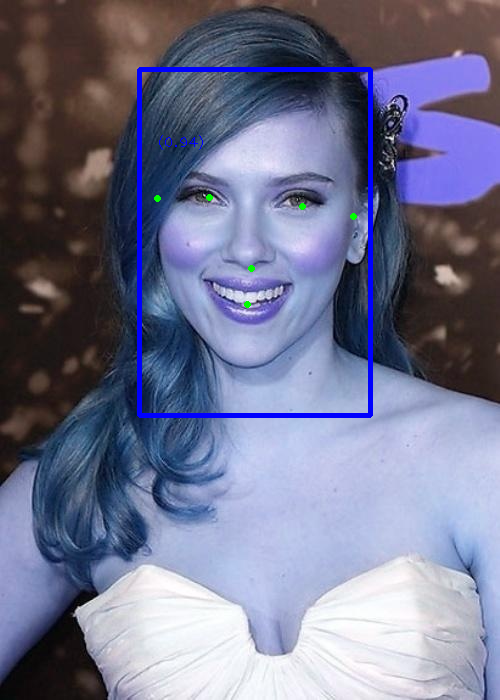

TypeError: 'module' object is not callable

In [40]:
# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)

# import PIL
# from IPython.display import Image
from PIL import Image


rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
# cv2.imshow(rgb_annotated_image)

pil_image = Image.fromarray(rgb_annotated_image)
pil_image.show()
display(Image(annotated_image))